# Analyzer power to find crosspol contribution

### Feb 26, 2021

## Code

In [1]:
import sys
import csv
# sys.path.insert(0,"/users/PCON0003/cond0068/.local/lib/python3.7/")
sys.path.append("/users/PAS0654/osu8354/ARA_cvmfs/root_build/lib/") # go to parent dir
sys.path.append("/users/PCON0003/cond0068/.local/lib/python3.7/site-packages/")
# sys.path.append("/users/PCON0003/cond0068/pyrex_sims/fromBen/thesis_work/pyrex-custom/analysis/custom/analysis/")
# import ROOT
import math
import numpy as np
# from ROOT import TH1D,TF1, gRandom, gPad, gStyle
import matplotlib as mpl
import matplotlib.pyplot as plt
# from ROOT import TChain, TSelector, TTree
import os
import matplotlib.colors as mcolors
import scipy
from matplotlib.colors import LogNorm
import pandas as pd
import pyrex
import seaborn as sns
%matplotlib inline
sys.path.insert(1, "/users/PAS0654/osu8354/ARA_cvmfs/source/AraRoot/analysis/ARA_analysis/CenA_sourceSearch/Stokes")
# import deDisperse_util as util
# from pyrex.internal_functions import normalize
my_path_plots = os.path.abspath("./plots/")
# import pyrex.custom.ara as ara


In [2]:
# mpl.use('agg') 
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.unicode'] = True
mpl.rcParams['mathtext.rm'] = 'Times New Roman'
mpl.rcParams['mathtext.it'] = 'Times New Roman:italic'
mpl.rcParams['mathtext.bf'] = 'Times New Roman:bold'

mpl.rc('font', family='serif', size=12)
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['ytick.major.size'] = 5

mpl.rcParams['axes.titlesize'] = 18
mpl.rcParams['axes.labelsize'] = 18
# mpl.rc('font', size=16)
mpl.rc('axes', titlesize=20)

current_palette = sns.color_palette('colorblind', 10)
import warnings
warnings.filterwarnings("ignore")

In [3]:
def rotation_matrix_from_vectors(vec1, vec2):
    """ Find the rotation matrix that aligns vec1 to vec2
    :param vec1: A 3d "source" vector
    :param vec2: A 3d "destination" vector
    :return mat: A transform matrix (3x3) which when applied to vec1, aligns it with vec2.
    """
    a, b = (vec1 / np.linalg.norm(vec1)).reshape(3), (vec2 / np.linalg.norm(vec2)).reshape(3)
    v = np.cross(a, b)
    c = np.dot(a, b)
    s = np.linalg.norm(v)
    kmat = np.array([[0, -v[2], v[1]], [v[2], 0, -v[0]], [-v[1], v[0], 0]])
    rotation_matrix = np.eye(3) + kmat + kmat.dot(kmat) * ((1 - c) / (s ** 2))
    return rotation_matrix

def rotatePolVector(launchVecSrc, recVec, PolVecAntenna):
    recVec = -recVec #receiving vector needs to be reflected, otherwise rotation matrix will be off by pi
    newPol = np.dot(PolVecAntenna,rotation_matrix_from_vectors(launchVecSrc,recVec))
    return newPol

def Rx(theta):
    return np.matrix([[ 1, 0           , 0           ],
                   [ 0, np.cos(theta),-np.sin(theta)],
                   [ 0, np.sin(theta), np.cos(theta)]])

#### From Dave Besson, the cross pol is of about 25%, and it's due to the transmitter beam pattern.

## Expected polarization 

In [4]:
def estimatePolRayTracer(depth):
    #Take depth of pulser and calculate polarization rotation based on raytracer results.
    rt = pyrex.RayTracer(from_point=(0, 0, -depth), to_point=(2400, 0, -179.93)) #Use the depth of the transmitter as the z-
    #coordinate. A2 is at a horizontal distance of 2400 m from the pulser, and at a depth of 179.93 m
    path = rt.solutions[0] #We only care about direct solutions
    rotMat = rotation_matrix_from_vectors(path.received_direction,path.emitted_direction)
    initPulserPol = np.array([0,0,1])
#     initPulserPol = np.array([np.sqrt(0.25/2),np.sqrt(0.25/2),np.sqrt(0.75)])
    rotAngle = np.pi/2-np.arccos(path.emitted_direction[2])
#     pulserPol = np.array(np.matmul(initPulserPol,Rx(rotAngle)))[0]
    rotatedPol = np.dot(initPulserPol,rotMat)
    newOmegaPol = np.degrees(np.arccos(rotatedPol[2]))
    return newOmegaPol-np.degrees(rotAngle)

# Load data

### Dec 26

In [5]:
SpiceCore0 = pd.read_pickle("../ARA_analysis/ARA_Reconstruction/RecoOmegaCh0_8_run_012577.pkl")
# SpiceCore0 = SpiceCore0.loc[SpiceCore0.theta_reco>=90]

SpiceCore1 = pd.read_pickle("../ARA_analysis/ARA_Reconstruction/RecoOmegaCh1_9_run_012577.pkl")
# SpiceCore1 = SpiceCore1.loc[SpiceCore1.theta_reco>=90]

SpiceCore2 = pd.read_pickle("../ARA_analysis/ARA_Reconstruction/RecoOmegaCh2_10_run_012577.pkl")
# SpiceCore2 = SpiceCore2.loc[SpiceCore2.theta_reco>=90]

SpiceCore3 = pd.read_pickle("../ARA_analysis/ARA_Reconstruction/RecoOmegaCh3_11_run_012577.pkl")
# SpiceCore3 = SpiceCore3.loc[SpiceCore3.theta_reco>=90]

SpiceCore4 = pd.read_pickle("../ARA_analysis/ARA_Reconstruction/RecoOmegaCh4_12_run_012577.pkl")
# SpiceCore4 = SpiceCore4.loc[SpiceCore4.theta_reco>=90]

SpiceCore5 = pd.read_pickle("../ARA_analysis/ARA_Reconstruction/RecoOmegaCh5_13_run_012577.pkl")
# SpiceCore5 = SpiceCore5.loc[SpiceCore5.theta_reco>=90]

SpiceCore6 = pd.read_pickle("../ARA_analysis/ARA_Reconstruction/RecoOmegaCh6_14_run_012577.pkl")
# SpiceCore6 = SpiceCore6.loc[SpiceCore6.theta_reco>=90]

In [6]:
depth_1226 = pd.read_csv("./plots/SpiceCorePolReco/A2_1226Depth.txt")
time = pd.to_datetime(depth_1226.NZ_Time)
# time = time.reindex(time)
# time = time.tz_localize('NZ').tz_convert("UTC")
time.head()
newTime = time.apply(lambda dt: dt.replace(day=26, month = 12, year = 2018))
# newTime#Still in NZ local time. Need to translate to UTC
df = pd.DataFrame(1, index=newTime, columns=['X'])
import pytz
nz = pytz.timezone('NZ')
utc = pytz.timezone('UTC')
df.index = df.index.tz_localize(nz).tz_convert(utc)
unixTimeDepth = (df.index - pd.Timestamp("1970-01-01").tz_localize(utc)) // pd.Timedelta('1s')#This is unix time 

In [7]:
f = scipy.interpolate.interp1d(unixTimeDepth, depth_1226.depth,bounds_error=False, fill_value=0.)
SpiceCore2ForInterp = SpiceCore2.loc[(SpiceCore2.unixtime>min(SpiceCore2.unixtime)) & (SpiceCore2.unixtime<3.5*1E3+1.54579*1E9)]
interp_depth = f(SpiceCore2ForInterp.unixtime)
SpiceCore2ForInterp["interp_depth"] = interp_depth

In [8]:
SpiceCore0ForInterp = SpiceCore0.loc[(SpiceCore0.unixtime>min(SpiceCore0.unixtime)) & (SpiceCore0.unixtime<3.5*1E3+1.54579*1E9)]
interp_depth = f(SpiceCore0ForInterp.unixtime)
SpiceCore0ForInterp["interp_depth"] = interp_depth

SpiceCore1ForInterp = SpiceCore1.loc[(SpiceCore1.unixtime>min(SpiceCore1.unixtime)) & (SpiceCore1.unixtime<3.5*1E3+1.54579*1E9)]
interp_depth = f(SpiceCore1ForInterp.unixtime)
SpiceCore1ForInterp["interp_depth"] = interp_depth

SpiceCore2ForInterp = SpiceCore2.loc[(SpiceCore2.unixtime>min(SpiceCore2.unixtime)) & (SpiceCore2.unixtime<3.5*1E3+1.54579*1E9)]
interp_depth = f(SpiceCore2ForInterp.unixtime)
SpiceCore2ForInterp["interp_depth"] = interp_depth

SpiceCore3ForInterp = SpiceCore3.loc[(SpiceCore3.unixtime>min(SpiceCore3.unixtime)) & (SpiceCore3.unixtime<3.5*1E3+1.54579*1E9)]
interp_depth = f(SpiceCore3ForInterp.unixtime)
SpiceCore3ForInterp["interp_depth"] = interp_depth

SpiceCore4ForInterp = SpiceCore4.loc[(SpiceCore4.unixtime>min(SpiceCore4.unixtime)) & (SpiceCore4.unixtime<3.5*1E3+1.54579*1E9)]
interp_depth = f(SpiceCore4ForInterp.unixtime)
SpiceCore4ForInterp["interp_depth"] = interp_depth

SpiceCore5ForInterp = SpiceCore5.loc[(SpiceCore5.unixtime>min(SpiceCore5.unixtime)) & (SpiceCore5.unixtime<3.5*1E3+1.54579*1E9)]
interp_depth = f(SpiceCore5ForInterp.unixtime)
SpiceCore5ForInterp["interp_depth"] = interp_depth

SpiceCore6ForInterp = SpiceCore6.loc[(SpiceCore6.unixtime>min(SpiceCore6.unixtime)) & (SpiceCore6.unixtime<3.5*1E3+1.54579*1E9)]
interp_depth = f(SpiceCore6ForInterp.unixtime)
SpiceCore6ForInterp["interp_depth"] = interp_depth

In [20]:
SpiceCore6ForInterp

,EvNum,Omega_reco,unixtime,SNR_V,SNR_H,theta_reco,power_V,power_H,powerV_noise,powerH_noise,interp_depth,Omega_reco2
1,8408,45.049790,1545787829,8.280617,1.011316,45.0,2.247058e+07,2.071045e+07,6.979042e+06,5.164978e+06,1441.650000,45.0
2,14725,46.525709,1545788957,8.151678,2.650173,40.0,2.201129e+07,2.188760e+07,6.979042e+06,5.164978e+06,1284.511905,50.0
3,19862,3.538807,1545789840,16.867103,2.546491,115.0,3.716380e+08,6.559614e+06,6.979042e+06,5.164978e+06,1140.000000,25.0
4,19952,7.693883,1545789857,14.379622,3.012198,114.0,5.555183e+08,1.517642e+07,6.979042e+06,5.164978e+06,1137.166667,24.0
5,20099,5.690687,1545789884,21.804438,2.997519,115.0,5.772374e+08,1.082761e+07,6.979042e+06,5.164978e+06,1132.666667,25.0
6,20329,6.196452,1545789924,34.302168,2.473993,114.0,4.385364e+08,1.025213e+07,6.979042e+06,5.164978e+06,1127.000000,24.0
7,22611,12.157900,1545790282,21.213089,0.133709,69.0,2.899082e+08,1.829680e+07,6.979042e+06,5.164978e+06,1076.333333,21.0
8,22843,9.594864,1545790321,23.821427,0.931748,113.0,7.137921e+08,2.536305e+07,6.979042e+06,5.164978e+06,1069.833333,23.0
9,23380,13.304966,1545790398,21.892469,2.920239,113.0,2.891047e+08,2.094243e+07,6.979042e+06,5.164978e+06,1057.000000,23.0
10,25363,8.311387,1545790711,16.603915,0.129982,111.0,2.485575e+08,1.032062e+07,6.979042e+06,5.164978e+06,1012.361111,21.0


In [21]:
SpiceCore6ForInterp["R"] = np.sqrt((SpiceCore6ForInterp.power_H-SpiceCore6ForInterp.powerH_noise)/(SpiceCore6ForInterp.power_V-SpiceCore6ForInterp.powerV_noise))
SpiceCore6ForInterp["Omega_reco2"] = np.degrees(np.arccos(np.sin(np.radians(SpiceCore6ForInterp.theta_reco))/np.sqrt(1+SpiceCore6ForInterp.R**2)))

Text(0,0.5,'$H_{power}$/$V_{power}$ [noise subtracted]')

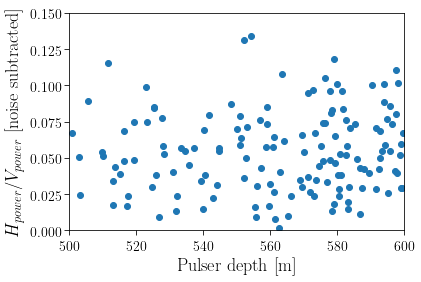

In [16]:
plt.scatter(SpiceCore0ForInterp.interp_depth, np.sqrt(SpiceCore0ForInterp.power_H-SpiceCore0ForInterp.powerH_noise)/np.sqrt(SpiceCore0ForInterp.power_V-SpiceCore0ForInterp.powerV_noise))
# plt.colorbar(label = "Counts")
# plt.yscale("log")
# plt.xscale("log")
plt.ylim(0,0.15)
plt.xlim(500,600)

plt.xlabel("Pulser depth [m]")
plt.ylabel("$H_{power}$/$V_{power}$ [noise subtracted]")

In [64]:
np.degrees(np.arctan(0.01))

0.5729386976834859

No handles with labels found to put in legend.


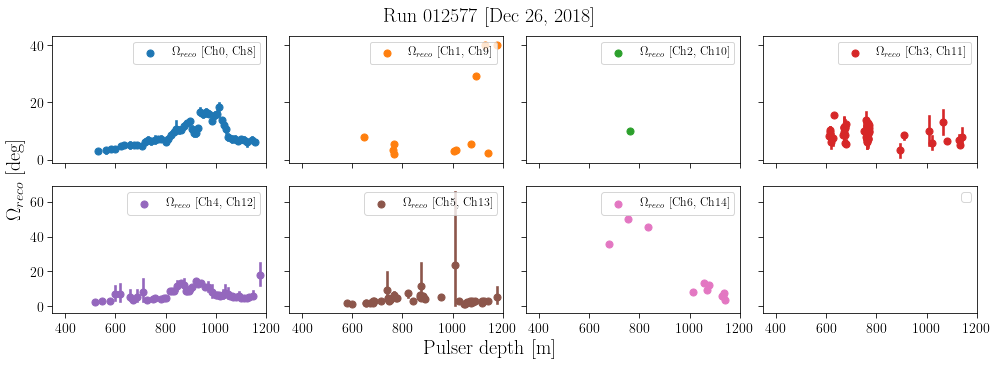

In [43]:
fig, ax = plt.subplots(2, 4, sharex='col', sharey='row', figsize=(14,5))
axs = ax.ravel()
sns.regplot(x=SpiceCore0ForInterp.interp_depth, y=SpiceCore0ForInterp.Omega_reco, x_bins=50, fit_reg=None, ax =axs[0], label = "$\Omega_{reco}$ [Ch0, Ch8]")
sns.regplot(x=SpiceCore1ForInterp.interp_depth, y=SpiceCore1ForInterp.Omega_reco, x_bins=50, fit_reg=None, ax =axs[1], label = "$\Omega_{reco}$ [Ch1, Ch9]")
sns.regplot(x=SpiceCore2ForInterp.interp_depth, y=SpiceCore2ForInterp.Omega_reco, x_bins=50, fit_reg=None, ax =axs[2], label = "$\Omega_{reco}$ [Ch2, Ch10]")
sns.regplot(x=SpiceCore3ForInterp.interp_depth, y=SpiceCore3ForInterp.Omega_reco, x_bins=50, fit_reg=None, ax =axs[3], label = "$\Omega_{reco}$ [Ch3, Ch11]")
sns.regplot(x=SpiceCore4ForInterp.interp_depth, y=SpiceCore4ForInterp.Omega_reco, x_bins=50, fit_reg=None, ax =axs[4], label = "$\Omega_{reco}$ [Ch4, Ch12]")
sns.regplot(x=SpiceCore5ForInterp.interp_depth, y=SpiceCore5ForInterp.Omega_reco, x_bins=50, fit_reg=None, ax =axs[5], label = "$\Omega_{reco}$ [Ch5, Ch13]")
sns.regplot(x=SpiceCore6ForInterp.interp_depth, y=SpiceCore6ForInterp.Omega_reco, x_bins=50, fit_reg=None, ax =axs[6], label = "$\Omega_{reco}$ [Ch6, Ch14]")

# axs[6].set_xlabel("unixTime")
fig.text(0.5, 0.03, 'Pulser depth [m]', ha='center', va='center', fontsize=20)
fig.text(0.03, 0.5, '$\Omega_{reco}$ [deg]', ha='center', va='center', rotation='vertical', fontsize=20)

for ax in axs:
#     ax.set_xlabel("a")
    ax.set_xlim(350,1200)
#     ax.set_ylim(0,25)
    ax.set(xlabel="", ylabel = "")
#     ax.plot(depthArr,pol,"--",lw=3,c ="darkviolet", label = "$\Omega_{true}$")


    ax.legend(loc="upper right")

plt.suptitle("Run 012577 [Dec 26, 2018]", fontsize=20)
plt.tight_layout(rect=[0.03, 0.03, 1, 0.95])
# plt.savefig(my_path_plots+'/SpiceCorePolReco/SpiceCoreScatterOmegaRecoTrueVsDepth_run012577_AllCh_reject_Profile_wSatCut.png', dpi=250)
# plt.savefig(my_path_plots+'/SpiceCorePolReco/SpiceCoreOmegaRecoTrueVsDepth_run012577_beforeDelays.png', dpi=250)


# Dec 24

In [24]:
SpiceCore0 = pd.read_pickle("../ARA_analysis/ARA_Reconstruction/RecoOmegaCh0_8_run_012559.pkl")
SpiceCore0 = SpiceCore0.loc[SpiceCore0.theta_reco>=90]

SpiceCore1 = pd.read_pickle("../ARA_analysis/ARA_Reconstruction/RecoOmegaCh1_9_run_012559.pkl")
SpiceCore1 = SpiceCore1.loc[SpiceCore1.theta_reco>=90]

SpiceCore2 = pd.read_pickle("../ARA_analysis/ARA_Reconstruction/RecoOmegaCh2_10_run_012559.pkl")
SpiceCore2 = SpiceCore2.loc[SpiceCore2.theta_reco>=90]

SpiceCore3 = pd.read_pickle("../ARA_analysis/ARA_Reconstruction/RecoOmegaCh3_11_run_012559.pkl")
SpiceCore3 = SpiceCore3.loc[SpiceCore3.theta_reco>=90]

SpiceCore4 = pd.read_pickle("../ARA_analysis/ARA_Reconstruction/RecoOmegaCh4_12_run_012559.pkl")
SpiceCore4 = SpiceCore4.loc[SpiceCore4.theta_reco>=90]

SpiceCore5 = pd.read_pickle("../ARA_analysis/ARA_Reconstruction/RecoOmegaCh5_13_run_012559.pkl")
SpiceCore5 = SpiceCore5.loc[SpiceCore5.theta_reco>=90]

SpiceCore6 = pd.read_pickle("../ARA_analysis/ARA_Reconstruction/RecoOmegaCh6_14_run_012559.pkl")
SpiceCore6 = SpiceCore6.loc[SpiceCore6.theta_reco>=90]

In [25]:
depth_1224 = pd.read_csv("./plots/SpiceCorePolReco/A2_1224Depth.txt")
time = pd.to_datetime(depth_1224.NZ_Time)
# time = time.reindex(time)
# time = time.tz_localize('NZ').tz_convert("UTC")
time.head()
newTime = time.apply(lambda dt: dt.replace(day=24, month = 12, year = 2018))
# newTime#Still in NZ local time. Need to translate to UTC
df = pd.DataFrame(1, index=newTime, columns=['X'])
import pytz
nz = pytz.timezone('NZ')
utc = pytz.timezone('UTC')
df.index = df.index.tz_localize(nz).tz_convert(utc)
unixTimeDepth = (df.index - pd.Timestamp("1970-01-01").tz_localize(utc)) // pd.Timedelta('1s')#This is unix time 

In [26]:
f = scipy.interpolate.interp1d(unixTimeDepth, depth_1224.depth,bounds_error=False, fill_value=0.)
SpiceCore2ForInterp = SpiceCore2.loc[(SpiceCore2.unixtime>min(SpiceCore2.unixtime)) & (SpiceCore2.unixtime<2.15*1E4+1.5456*1E9)]
interp_depth = f(SpiceCore2ForInterp.unixtime)
SpiceCore2ForInterp["interp_depth"] = interp_depth

In [27]:
SpiceCore0ForInterp = SpiceCore0.loc[(SpiceCore0.unixtime>min(SpiceCore0.unixtime)) & (SpiceCore0.unixtime<2.15*1E4+1.5456*1E9)]
interp_depth = f(SpiceCore0ForInterp.unixtime)
SpiceCore0ForInterp["interp_depth"] = interp_depth

SpiceCore1ForInterp = SpiceCore1.loc[(SpiceCore1.unixtime>min(SpiceCore1.unixtime)) & (SpiceCore1.unixtime<2.15*1E4+1.5456*1E9)]
interp_depth = f(SpiceCore1ForInterp.unixtime)
SpiceCore1ForInterp["interp_depth"] = interp_depth

SpiceCore2ForInterp = SpiceCore2.loc[(SpiceCore2.unixtime>min(SpiceCore2.unixtime)) & (SpiceCore2.unixtime<2.15*1E4+1.5456*1E9)]
interp_depth = f(SpiceCore2ForInterp.unixtime)
SpiceCore2ForInterp["interp_depth"] = interp_depth

SpiceCore3ForInterp = SpiceCore3.loc[(SpiceCore3.unixtime>min(SpiceCore3.unixtime)) & (SpiceCore3.unixtime<2.15*1E4+1.5456*1E9)]
interp_depth = f(SpiceCore3ForInterp.unixtime)
SpiceCore3ForInterp["interp_depth"] = interp_depth

SpiceCore4ForInterp = SpiceCore4.loc[(SpiceCore4.unixtime>min(SpiceCore4.unixtime)) & (SpiceCore4.unixtime<2.15*1E4+1.5456*1E9)]
interp_depth = f(SpiceCore4ForInterp.unixtime)
SpiceCore4ForInterp["interp_depth"] = interp_depth

SpiceCore5ForInterp = SpiceCore5.loc[(SpiceCore5.unixtime>min(SpiceCore5.unixtime)) & (SpiceCore5.unixtime<2.15*1E4+1.5456*1E9)]
interp_depth = f(SpiceCore5ForInterp.unixtime)
SpiceCore5ForInterp["interp_depth"] = interp_depth

SpiceCore6ForInterp = SpiceCore6.loc[(SpiceCore6.unixtime>min(SpiceCore6.unixtime)) & (SpiceCore6.unixtime<2.15*1E4+1.5456*1E9)]
interp_depth = f(SpiceCore6ForInterp.unixtime)
SpiceCore6ForInterp["interp_depth"] = interp_depth

In [28]:
SpiceCore6ForInterp["R"] = np.sqrt((SpiceCore6ForInterp.power_H-SpiceCore6ForInterp.powerH_noise)/(SpiceCore6ForInterp.power_V-SpiceCore6ForInterp.powerV_noise))
SpiceCore6ForInterp["Omega_reco2"] = np.degrees(np.arccos(np.sin(np.radians(SpiceCore6ForInterp.theta_reco))/np.sqrt(1+SpiceCore6ForInterp.R**2)))

No handles with labels found to put in legend.


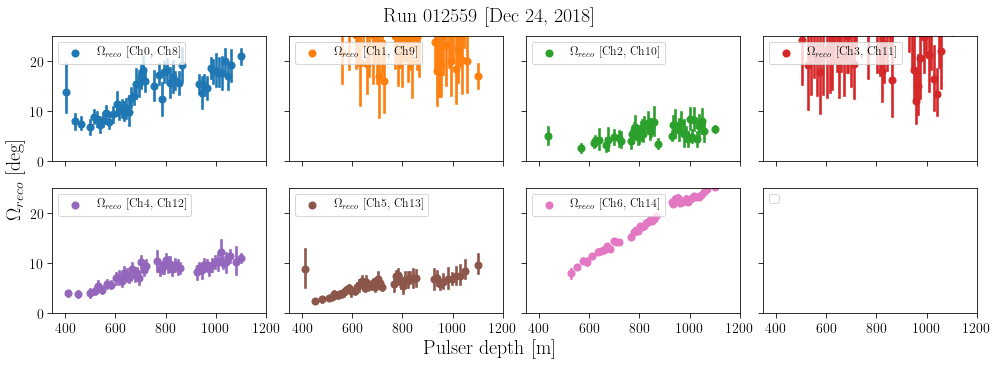

In [32]:
fig, ax = plt.subplots(2, 4, sharex='col', sharey='row', figsize=(14,5))
axs = ax.ravel()
sns.regplot(x=SpiceCore0ForInterp.interp_depth, y=SpiceCore0ForInterp.Omega_reco, x_bins=50, fit_reg=None, ax =axs[0], label = "$\Omega_{reco}$ [Ch0, Ch8]")
sns.regplot(x=SpiceCore1ForInterp.interp_depth, y=SpiceCore1ForInterp.Omega_reco, x_bins=50, fit_reg=None, ax =axs[1], label = "$\Omega_{reco}$ [Ch1, Ch9]")
sns.regplot(x=SpiceCore2ForInterp.interp_depth, y=SpiceCore2ForInterp.Omega_reco, x_bins=50, fit_reg=None, ax =axs[2], label = "$\Omega_{reco}$ [Ch2, Ch10]")
sns.regplot(x=SpiceCore3ForInterp.interp_depth, y=SpiceCore3ForInterp.Omega_reco, x_bins=50, fit_reg=None, ax =axs[3], label = "$\Omega_{reco}$ [Ch3, Ch11]")
sns.regplot(x=SpiceCore4ForInterp.interp_depth, y=SpiceCore4ForInterp.Omega_reco, x_bins=50, fit_reg=None, ax =axs[4], label = "$\Omega_{reco}$ [Ch4, Ch12]")
sns.regplot(x=SpiceCore5ForInterp.interp_depth, y=SpiceCore5ForInterp.Omega_reco, x_bins=50, fit_reg=None, ax =axs[5], label = "$\Omega_{reco}$ [Ch5, Ch13]")
sns.regplot(x=SpiceCore6ForInterp.interp_depth, y=SpiceCore6ForInterp.Omega_reco2, x_bins=50, fit_reg=None, ax =axs[6], label = "$\Omega_{reco}$ [Ch6, Ch14]")

# axs[6].set_xlabel("unixTime")
fig.text(0.5, 0.03, 'Pulser depth [m]', ha='center', va='center', fontsize=20)
fig.text(0.03, 0.5, '$\Omega_{reco}$ [deg]', ha='center', va='center', rotation='vertical', fontsize=20)

for ax in axs:
#     ax.set_xlabel("a")
    ax.set_xlim(350,1200)
    ax.set_ylim(0,25)
    ax.set(xlabel="", ylabel = "")
#     ax.plot(depthArr,pol,"--",lw=3,c ="darkviolet", label = "$\Omega_{true}$")


    ax.legend(loc="upper left")

plt.suptitle("Run 012559 [Dec 24, 2018]", fontsize=20)
plt.tight_layout(rect=[0.03, 0.03, 1, 0.95])
# plt.savefig(my_path_plots+'/SpiceCorePolReco/SpiceCoreOmegaRecoTrueVsDepth_run012559_beforeDelays.png', dpi=250)


In [ ]:
fig, ax = plt.subplots(2, 4, sharex='col', sharey='row', figsize=(14,5))
axs = ax.ravel()
sns.regplot(x=SpiceCore0ForInterp.interp_depth, y=SpiceCore0ForInterp.SNR_V, x_bins=40, ax =axs[0], label = "Ch0")
sns.regplot(x=SpiceCore1ForInterp.interp_depth, y=SpiceCore1ForInterp.SNR_V, x_bins=40, ax =axs[1], label = "Ch1")
sns.regplot(x=SpiceCore2ForInterp.interp_depth, y=SpiceCore2ForInterp.SNR_V, x_bins=40, ax =axs[2], label = "Ch2")
sns.regplot(x=SpiceCore3ForInterp.interp_depth, y=SpiceCore3ForInterp.SNR_V, x_bins=40, ax =axs[3], label = "Ch3")
sns.regplot(x=SpiceCore4ForInterp.interp_depth, y=SpiceCore4ForInterp.SNR_V, x_bins=40, ax =axs[4], label = "Ch4")
sns.regplot(x=SpiceCore5ForInterp.interp_depth, y=SpiceCore5ForInterp.SNR_V, x_bins=40, ax =axs[5], label = "Ch5")
sns.regplot(x=SpiceCore6ForInterp.interp_depth, y=SpiceCore6ForInterp.SNR_V, x_bins=40, ax =axs[6], label = "Ch6")

# axs[6].set_xlabel("unixTime")
fig.text(0.5, 0.03, 'Pulser depth [m]', ha='center', va='center', fontsize=20)
fig.text(0.03, 0.5, 'SNR', ha='center', va='center', rotation='vertical', fontsize=20)

for ax in axs:
#     ax.set_xlabel("a")
    ax.set_xlim(350,1000)
    ax.set_ylim(10,60)
    ax.set(xlabel="", ylabel = "")

    ax.legend(loc="upper right")

plt.suptitle("Run 012559 [Dec 24, 2018]", fontsize=20)
plt.tight_layout(rect=[0.03, 0.03, 1, 0.95])
# plt.savefig(my_path_plots+'/SpiceCorePolReco/SpiceCorePolSNRVsDepth_run012559_AllCh_reject_Profile.png', dpi=250)


In [ ]:
fig, ax = plt.subplots(2, 4, sharex='col', sharey='row', figsize=(14,5))
axs = ax.ravel()
sns.regplot(x=SpiceCore0ForInterp.interp_depth, y=SpiceCore0ForInterp.SNR_H, x_bins=40, ax =axs[0], label = "Ch8")
sns.regplot(x=SpiceCore1ForInterp.interp_depth, y=SpiceCore1ForInterp.SNR_H, x_bins=40, ax =axs[1], label = "Ch9")
sns.regplot(x=SpiceCore2ForInterp.interp_depth, y=SpiceCore2ForInterp.SNR_H, x_bins=40, ax =axs[2], label = "Ch10")
sns.regplot(x=SpiceCore3ForInterp.interp_depth, y=SpiceCore3ForInterp.SNR_H, x_bins=40, ax =axs[3], label = "Ch11")
sns.regplot(x=SpiceCore4ForInterp.interp_depth, y=SpiceCore4ForInterp.SNR_H, x_bins=40, ax =axs[4], label = "Ch12")
sns.regplot(x=SpiceCore5ForInterp.interp_depth, y=SpiceCore5ForInterp.SNR_H, x_bins=40, ax =axs[5], label = "Ch13")
sns.regplot(x=SpiceCore6ForInterp.interp_depth, y=SpiceCore6ForInterp.SNR_H, x_bins=40, ax =axs[6], label = "Ch14")

# axs[6].set_xlabel("unixTime")
fig.text(0.5, 0.03, 'Pulser depth [m]', ha='center', va='center', fontsize=20)
fig.text(0.03, 0.5, 'SNR', ha='center', va='center', rotation='vertical', fontsize=20)

for ax in axs:
#     ax.set_xlabel("a")
    ax.set_xlim(350,1000)
    ax.set_ylim(0,6)
    ax.set(xlabel="", ylabel = "")

    ax.legend(loc="upper right")

plt.suptitle("Run 012559 [Dec 24, 2018]", fontsize=20)
plt.tight_layout(rect=[0.03, 0.03, 1, 0.95])
# plt.savefig(my_path_plots+'/SpiceCorePolReco/SpiceCorePolSNRVsDepth_run012559_AllCh_reject_ProfileHpol.png', dpi=250)


Text(0.5,1,'$\\Delta\\Omega$ for SpiceCore events using a single channel pair')

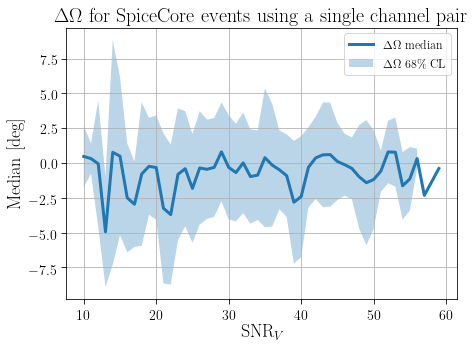

In [20]:
plt.figure(figsize=(7,5))

plt.plot(SNR_arr,meanV, lw = 3,label="$\Delta \Omega$ median")
plt.fill_between(SNR_arr,meanV-sigmaV,meanV+sigmaV, alpha = 0.3, label="$\Delta \Omega$ 68\% CL")
plt.xlabel("SNR$_{V}$")
plt.ylabel("Median [deg]")
plt.grid()
plt.legend()
plt.title("$\Delta\Omega$ for SpiceCore events using a single channel pair")
# plt.savefig(my_path_plots+'/SpiceCorePolReco/deltaOmegaVsSNR_preliminary.png', dpi=250)